In [1]:
import numpy as np
from scipy.optimize import*
import math 
import random 
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sympy import *

In [49]:
#Dados:

class Parametros():
    
    def __init__(self):
        
        #PARÂMETROS
        
        #ÁREA ABERTA AO FLUXO E COMPRIMENTO:
        #unidade: cm²
        area = 12
        self.area = area
        #unidade: cm
        length = 40
        self.length = length
        
        # VOLUME POROSO:
        #unidade: cm³ 
        total_volume = area*length
        porosity = 0.25
        self.porosity = porosity
        porous_volume = total_volume*porosity
        self.porous_volume = porous_volume
        
        #Vazão de injeção: constante
        #unidade: cm³/min
        qinj = 0.500
        self.qinj = qinj
        
        # SATURAÇÃO EM %:
        
        #saturação irredutível de água:
        swi = 0.15
        self.swi = swi
        #valores de saturação
        sw = np.linspace(swi,0.7,20)
        self.sw = sw

        #saturação de óleo residual
        sor = 0.3
        self.sor = sor
        #Lembrando: Sw = 1 - Sor -> Fw = 1
        
        # VOLUME INICIAL DE ÓLEO:
        oil_volume = porous_volume*(1-swi)
        self.oil_volume = oil_volume
        
        #VISCOSIDADE EM cP:
        viscosity_water = 1.0
        self.viscosity_water = viscosity_water
        viscosity_polymer = 15
        self.viscosity_polymer = viscosity_polymer
        #Outras viscosidades de polímero: 5cP,10cP
        viscosity_oil = 200
        self.viscosity_oil = viscosity_oil
    
        viscosity_ratio_wo = viscosity_water/viscosity_oil
        viscosity_ratio_po = viscosity_polymer/viscosity_oil
        self.viscosity_ratio_wo = viscosity_ratio_wo
        self.viscosity_ratio_po = viscosity_ratio_po

        #Dados do polímero:
        Di = 0.106
        self.Di = Di
        Swi_Di = -Di
        self.Swi_Di = Swi_Di
        
        #Swi = -Di até Sw = 1 - Sor
        sw_po = np.linspace(self.Swi_Di,0.7,20)
        self.sw_po = sw_po
        
    def permeabilityRatio(self,SW):
        
        #MODELO DE COREY
        
        #Para obtenção das regras estabelicidas por Craig em 1971:
        #Molhabilidade ao óleo: alfa_w = 0.6 e n = 1.5
        #Molhabilidade à água: alfa_w = 0.1 e n = 2.0
        #Molhabilidade intermediária: alfa_w = 0.3 e n = 2.0
        
        ########################################################################
        #alfa_w - Krelativo à água no Sor
        alfa_w = 0.1
        self.alfa_w = alfa_w
        #alfa_o - Krelativo ao óleo na Swi
        alfa_o = 0.8
        self.alfa_o = alfa_o
        #######################33###############################################
        #n e m (exp. de COREY) - Definem o formato das curvas entre os pontos terminais
        n = 2.0
        self.n = n
        m = 2.0
        self.m = m
        ########################################################################
        #EQUAÇÕES DE PERMEABILIDADE RELATIVA
        krw = alfa_w*((SW-self.swi)/(1-self.swi-self.sor))**n
        kro = alfa_o*((1-self.sor-SW)/(1-self.swi-self.sor))**m
        ########################################################################
        print(SW)
        print(krw)
        print(kro)
        self.krw = krw
        self.kro = kro
        
        permeability_ratio = kro/krw
        return(permeability_ratio)
    
    def wettability(self):
        
        x = symbols('x')
        init_printing(use_unicode = True)
        ########################################################################
        #EQUAÇÕES DE PERMEABILIDADE RELATIVA
        Eq_Krw = self.alfa_w*((x-self.swi)/(1-self.swi-self.sor))**self.n
        Eq_Kro = self.alfa_o*((1-self.sor-x)/(1-self.swi-self.sor))**self.m
        ########################################################################
        equate = Eq(Eq_Krw,Eq_Kro)
        solution = solve(equate)
        wettability = round(solution[0],2)
        Kr_wettability = Eq_Krw.subs(x,wettability)
        Kr_wettability = round(Kr_wettability,2)
        
        percentege  = abs((0.5-wettability)/0.5)
        percentege = round(percentege,2)
        
        if percentege == 0.05:
            wettability = 0.5
        else:
            pass
        
        if  wettability > 0.5:
            printing = "MOLHÁVEL A ÁGUA"
            
        elif wettability == 0.5:
            printing = "MOLHABILIDADE NEUTRA"
            
        else: 
            printing = "MOLHÁVEL A ÓLEO"
            
        ########################################################################
        #GRÁFICOS DE PERMEABILIDADE RELATIVA:
        fig,ax = plt.subplots(figsize = (10,10))
        ax.grid = True
        
        plt.plot(self.sw,self.krw,'b--',label='Krw')
        plt.plot(self.sw,self.kro,'r--',label='Kro')
        plt.plot(wettability,Kr_wettability,'go',label= printing)
        plt.title('Permeabilidade Relativa (KRW X KRO)',fontsize = 15)
        ax.annotate('     ({},{})'.format(wettability,Kr_wettability),xy=(wettability,Kr_wettability),xytext=(0.52, 0.09),fontsize = 10)
        
        plt.plot(self.swi,self.kro[0],'ro')
        ax.annotate(' ({},{})'.format(self.swi,round(self.kro[0],2)),xy=(self.swi,self.kro[0]),xytext=(0.14, 0.81),fontsize = 10)
        sw_max = 1-self.sor
        plt.plot(sw_max,self.alfa_w,'bo')
        ax.annotate('({},{})'.format(sw_max,self.alfa_w),xy=(sw_max,self.alfa_w),xytext=(0.68, 0.12),fontsize = 10)
        
        plt.plot(sw_max,self.kro[19],'ro')
        ax.annotate('({},{})'.format(sw_max,self.kro[19]),xy=(sw_max,self.kro[19]),xytext=(0.68, 0.02),fontsize = 10)
        
        plt.plot(self.swi,self.krw[0],'bo')
        ax.annotate('({},{})'.format(self.swi,self.krw[0]),xy=(sw_max,self.kro[19]),xytext=(0.14, 0.02),fontsize = 10)
        
        plt.legend()
        plt.show()
        ########################################################################
        #TABELA COM VALORES DE PERMEABILIDADE RELATIVA:
        kr_table = {'Saturação - ÁGUA':self.sw,'Kr - ÁGUA': self.krw, 'Kr - ÓLEO': self.kro}
        table_Kr = DataFrame(kr_table,index=range(1,21))
        #table_Kr=table_Kr.style.highlight_max(subset=['Saturação - ÁGUA'],color = 'yellow')
        #table_Kr=table_Kr.style.highlight_max(subset=['Saturação - ÁGUA'],color = 'yellow')
        self.table_Kr = table_Kr
    def fwFunctions(self):
        #Input de Sw para encontrarpermeabilityRatio, em que deve
        #ser repassado esses Sw's para a função permeabiltyRatio() e 
        #em seguida retornar o resultado para a função fw 
        #self.values_sw = sw
        fw_wo = (1/(1+self.viscosity_ratio_wo*self.permeabilityRatio(self.sw)))
        self.fw_wo = fw_wo
        
        fw_po = (1/(1+self.viscosity_ratio_po*self.permeabilityRatio(self.sw)))
        self.fw_po = fw_po
        
        #Variáveis para o gráfico:
        fw_wo_graph = fw_wo
        self.fw_wo_graph = fw_wo_graph
        fw_po_graph = fw_po
        self.fw_po_graph = fw_po_graph
        
    """def flowFractionary(self):
        #Fwf=self.fw(self.Swf)
        #self.Fwf = Fwf
        #Swf_eq = self.Swmedio*self.Fwf+(1-self.Fwf)*self.swi
        Fw = self.fwFunctions(self.sw)"""
        
    def mobilityRatio(self):
        #Razão de mobilidade terminal -> K'w e K'o são respectivamente krw no sor e kro na swi
        #Alterar apenas a viscosidade do fluido deslocante (simulando a adição de polímeros)
        MobRatio = (self.alfa_w/self.viscosity_polymer)/(self.alfa_o/self.viscosity_oil)
        MobRatio = round(MobRatio,2)
        return MobRatio
        
    def solve(self):
        #Gerar uma lista de valores aleatórios uniformemente distribuídos
        #a partir da saturação de água maior do que a Swi até 1.
        list_wo = []
        for i in range(0,100000):
            sw_values_wo = random.uniform(self.swi+0.01, 1)
            list_wo.append(sw_values_wo)
            
        array_wo = np.array(list_wo)
        self.array_wo = array_wo
        
        list_po = []
        for i in range(0,100000):
            sw_values_po = random.uniform(self.swi+0.01,1)
            list_po.append(sw_values_po)
        
        array_po = np.array(list_po)
        self.array_po = array_po
    
        #Calcular diferentes inclinações de retas tangentes à curva de fluxo
        #fracionário usando a array gerada com valores de saturação de água
        
        m_wo = 1/((self.array_wo-self.swi)*(1+(self.viscosity_ratio_wo)*self.permeabilityRatio(self.array_wo)))
        m_po = 1/((self.array_po-self.Swi_Di)*(1+(self.viscosity_ratio_po)*self.permeabilityRatio(self.array_po)))
        
        #Calcular a máxima inclinação obtida "m". O valor dessa inclinação será
        #a inclinação da reta tangente para a curva de FF.  
        index_mWO_max = np.where(m_wo==max(m_wo))
        index_mPO_max = np.where(m_po==max(m_po))
    
        
        #Encontrando a saturação de frente de avanço da água e do polímero:
        Swf_wo = self.array_wo[index_mWO_max]
        Swf_po = self.array_po[index_mPO_max]
        Swf_wo = round(Swf_wo[0],4)
        Swf_po = round(Swf_po[0],4)
        self.Swf_wo = Swf_wo
        self.Swf_po = Swf_po
        ########################################################################
        #Inclinação máxima:
        tangent_slope_wo = max(m_wo)
        tangent_slope_round_wo = round(tangent_slope_wo,4)
        self.tangent_slope_round_wo = tangent_slope_round_wo
    
        
        tangent_slope_po = max(m_po)
        tangent_slope_round_po = round(tangent_slope_po,4)
        self.tangent_slope_round_po = tangent_slope_round_po
        ########################################################################
        
        #ENCONTRANDO SW1,FW1,FWF,SWF_POLÍMERO E FWF_POLÍMERO:
        
        SW = symbols('SW')
        init_printing(use_unicode = True)
        #####################################################
        #y = fw da solução de polímero
        y_one = self.tangent_slope_round_po*(SW-self.Swi_Di)
        #####################################################
        krw = self.alfa_w*((SW-self.swi)/(1-self.swi-self.sor))**self.n
        kro = self.alfa_o*((1-self.sor-SW)/(1-self.swi-self.sor))**self.m
        kr_ratio = kro/krw
        self.kr_ratio = kr_ratio
        #####################################################
        # y_two - fw da água  
        y_two= 1/(1+self.viscosity_ratio_wo*(kr_ratio))
        self.y_two = y_two
        # y_three - fw do polímero
        y_three = 1/(1+self.viscosity_ratio_po*(kr_ratio))
        self.y_three = y_three
        #####################################################
        #Equação
        equate = Eq(y_one,y_two)
        #Solução
        solution = solve(equate)
        values = list(solution)
        print("Valores de Sw1 encontrados:",values)
        ####################################################
        if len(values) > 1:
            Sw1=solution[min(range(len(solution)), key = lambda i: abs(solution[i]-self.Swf_wo))]
            Sw1 = str(Sw1)
            Sw1 = Sw1[0:10]
            Sw1 = round(float(Sw1),4)
            self.Sw1 = Sw1
            
            Fw1 = round(y_two.subs(SW,Sw1),4)
            self.Fw1 = Fw1    
        else:
            Sw1 = round(values[0],4)
            self.Sw1 = Sw1
            
            Fw1 = round(y_two.subs(SW,values[0]),4)
            self.Fw1 = Fw1

            
        ###################################################
        #Encontrando Fwf da Swf da água e Fwf da Swf do polímero:
        
        Fwf_wo = y_two.subs(SW,self.Swf_wo)
        Fwf_wo = round(Fwf_wo,4)
        self.Fwf_wo = Fwf_wo
        
        Fwf_po = round(y_three.subs(SW,self.Swf_po),4)
        self.Fwf_po = Fwf_po
        
        ########################################################################
        #Gerando tabela com valores de Saturação e Fluxo Fracionário:
        dataBase = {'Saturação':[self.Swf_wo,self.Sw1,self.Swf_po],'Fluxo Fracionário':[self.Fwf_wo,self.Fw1,self.Fwf_po]}
        table_FF = DataFrame(dataBase,index = ['(Swf,Fwf)','(Sw1,Fw1)','(Sw*3,Fw*3)'])
        self.table_FF = table_FF
        return self.table_FF
        
    def SwMedio(self):
        #SwMédio: y = m*(Sw-Swi),no ponto (Swbt,1)
        Sw_medio_wat = self.swi + 1/self.tangent_slope_round_wo
        self.Sw_medio_wat= Sw_medio_wat
        print(self.Sw_medio_wat)
        
        Sw_medio_pol = self.swi + 1/self.tangent_slope_round_po
        self.Sw_medio_pol = Sw_medio_pol
        print(self.Sw_medio_pol)
        
    def posicaoADM(self):
        
        
        ax_x = [0.7] #x_inicial = 0.7 (Sw = 1-Sor)
        ax_y = [0]   #y_inicial = 0 (xd = 0)
        ####################################################################
        #tempo adimensional - reflete o número de volumes porosos injetados
            # td = qt*t/(A*L*Porosidade) ; 
        #qt - q de inj;
        #t - tempo decorrido desde o início da inj:
        #elapsed_time = 100
        #A - área da seção transversal
        #td_calculated = (self.qinj*elapsed_time/self.porous_volume)
        td = 0.03
        #distância adimensional:
    
        ####################################################################
        #BANCO DE POLÍMERO:
        
        #Sw1 > Swf e Sw1 < Swf:        
        
        """sw_values_po = np.linspace(0.7-0.01,self.Swf_po+0.01,5)
        for i in sw_values_po:
            ax_x.append(i)
            print(ax_x)
            
            inj_volume = i*self.porous_volume*td
            inj_time = inj_volume/self.qinj
            print("tempo",inj_time)
            #BL equation:
            #foward_velocity= (self.qinj/(self.area*self.porosity))*(self.tangent_slope_round_po)
            foward_velocity = 0.6017
            print(foward_velocity)
            position = inj_time*foward_velocity
            print("Posição",position)
            adm_position = position/self.length
            ax_y.append(adm_position)
            print("Posição ADM",adm_position)"""

        #xd =< xdfPol
        xd_po = td*(self.Fwf_po/(self.Swf_po+self.Di))
        print("Frente de avanço do polímero",xd_po)
        
        
        ax_x.append(self.Swf_po)
        ax_y.append(xd_po)
        
        ####################################################################
        #BANCO DE ÁGUA:
        #Sw1 > Swf e Sw1 < Swf:
        
        #xdfPol < xd =< xd1 -> Sw = Sw1
        ax_y.append(xd_po)
        ax_x.append(self.Sw1)
        
        ####################################################################
        #BANCO DE ÁGUA:
        
        #Sw1 > Swf:
        
        if self.Sw1 > self.Swf_wo:
        #xd1 =< xd =< xdf
        
            #xd1
            tangent_slope_round_w1 = round((self.Fw1/(self.Sw1 - self.swi)),4)
            xd1 = td*tangent_slope_round_w1   
        
            ax_y.append(xd1)
            ax_x.append(self.Sw1)
        
            #xdf
            xdf = td*self.tangent_slope_round_wo
            print(xdf)
        
            ax_y.append(xd1)
            ax_x.append(self.Swf_wo)
        
            #xd > xdf -> Sw = Swi
            ax_y.append(xdf)
            ax_x.append(self.Swf_wo)
        
            ax_y.append(xdf)
            ax_x.append(self.swi)
            
            ax_y.append(1)
            ax_x.append(self.swi)
            
        #Sw1 < Swf:
        else:
            
            xd1= td*(self.Fw1/(self.Sw1-self.swi))
        
            ax_y.append(xd1)
            ax_x.append(self.Sw1)
            
            ax_y.append(xd1)
            ax_x.append(self.swi)
            
            ax_y.append(1)
            ax_x.append(self.swi)
        #####################################################################
        #PLOTE DO GRÁFICO:
        plt.title('Frente de avanço dos bancos de água e polímero')
        plt.xlabel('Distância adimensional')
        plt.ylabel('Saturação de água')
        plt.plot(ax_y,ax_x)
        plt.show()
    
    def tempoBT(self):
        ###################################################
        #TEMPO DE IRRUPÇÃO DA ÁGUA:

        if self.Sw1 < self.Swf_wo:
            #Para Sw1<Swf:

            #tempoBT = 1/(Fw1/(Sw1-Swi))
            tempoBT_1 = 1/(self.Fw1/(self.Sw1-self.swi))
            tempoBT = tempoBT_1
            self.tempoBT = round(tempoBT,3)
            
        
        else:
            #Para Sw1>Swf:

            #tempoBT = 1/(dFw/dSw)Swf
            tempoBT_Wat = (1/self.tangent_slope_round_wo)
            tempoBT = tempoBT_Wat
            self.tempoBT = round(tempoBT,3)
            

        ##################################################################### 
        #TEMPO DE IRRUPÇÃO DO POLÍMERO

        #Para Sw1 < Swf e Para Sw1 > Swf:

        #tempoBT = 1/(Fwf_pol/(Swf_po+Di))

        tempoBT_Pol = 1/(self.Fwf_po/(self.Swf_po+self.Di))
        self.tempoBT_Pol = round(tempoBT_Pol,3)
        
    
        #####################################################################
        #TABELA PARA TEMPO DE BREAKTHROUGH:
        database = {'Tempo BT':[self.tempoBT,self.tempoBT_Pol]}
        table_BT = DataFrame(database, index=['Tempo BT - ÁGUA','Tempo BT - POLÍMERO'])
        return table_BT

    def recoveryFactor(self):
        self.tempoBT()
        
        #TOME NOTA: 
        #Swe - Saturação de água em xd = 1
        #Fwe - Fluxo fracionário de água em xd = 1
        
        #####################################################################
        #Sw1 > Swf e Sw1 < Swf:
        
        #td < tdBT = tdf -> Npd = Wid = td (Antes da irrupção de água)
        #Np_Before_BT = self.tempoBT
        
        
        #####################################################################
        #Sw1 > Swf:
        if self.Sw1 > self.Swf_wo:
            #tdf =< td =< td1 -> Npd = Swmédio - Swi = [Swe + td(1-Fwe)]- Swi (Após a irrupção de água)
            Npd_BT_Water= round((self.Swf_wo + self.tempoBT*(1-self.Fwf_wo) - self.swi),3)
            Np_BT_Water= round(Npd_BT_Water*self.porous_volume,3)
            Recovery_Factor_BT_Water = round(Np_BT_Water/self.oil_volume,4)            
        #SW1 < Swf:    
        else:
            #tdf =< td =< td1 -> Npd = Swmédio - Swi = [Swe + td(1-Fwe)]- Swi (Após a irrupção de água)
            Npd_BT_Water= round((self.Sw1 + self.tempoBT*(1-self.Fw1)- self.swi),3)
            Np_BT_Water= round(Npd_BT_Water*self.porous_volume,3)
            Recovery_Factor_BT_Water = round(Np_BT_Water/self.oil_volume,4)
        #####################################################################
        #Sw1 > Swf e Sw1 < Swf:
        
        #td >= td3 -> Npd = Swmédio - Swi = [SwePolímero + td(1-FwePolímero)] - Swi
        Npd_BT_Pol= round((self.Swf_po + self.tempoBT_Pol*(1-self.Fwf_po)- self.swi),3)
        Np_BT_Pol= round(Npd_BT_Pol*self.porous_volume,3)
        Recovery_Factor_BT_Polymer = round(Np_BT_Pol/self.oil_volume,4)
        
        #####################################################################
        #GERANDO A TABELA DOS NPD'S, NP'S E FATORES DE RECUPERAÇÃO PARA O TEMPO DE BT:
        values = [[self.tempoBT,Npd_BT_Water,Np_BT_Water,Recovery_Factor_BT_Water],[self.tempoBT_Pol,Npd_BT_Pol,Np_BT_Pol,Recovery_Factor_BT_Polymer]]
        table = DataFrame(values, columns=['TEMPO BT (tD)','NpD','Np','FR (%)'],index=['ÁGUA','POLÍMERO'])
        return table
        
        
    def linearGraphs(self):
        #reta tangente à curva de fluxo fracionário da água:
        tangent_wo = (self.sw-self.swi)*self.tangent_slope_round_wo
        self.tangent_wo = tangent_wo
        #reta tangente à curva de fluxo fracionário do polímero:
        tangent_po = (self.sw_po-self.Swi_Di)*self.tangent_slope_round_po
        self.tangent_po = tangent_po
        
    def plot(self):
        
        self.linearGraphs()
        # Making the plots
        fig, ax = plt.subplots(figsize =(10,6),constrained_layout=True)
        plt.title('FLUXO FRACIONÁRIO')
        plt.text(0.60,1.03,f'Razão de Mobilidade = {self.mobilityRatio()}',fontsize =16.0,bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
        plt.xlabel('Saturação de água')
        plt.ylabel('Fluxo Fracionário')
        
        
        fractional_flow_curve = ax.plot(self.sw,self.fw_wo_graph, 'b-', label = 'Fluxo Fracionário - Água')
        fractional_flow_curve = ax.plot(self.sw,self.fw_po_graph, 'r-', label = 'Fluxo Fracionário - Polímero')
        
        water_front = ax.plot(self.Swf_wo,self.Fwf_wo, "bo", label ='(Swf,Fwf)')
        plt.text(self.Swf_wo-0.25,self.Fwf_wo,f'{round(self.Swf_wo,4),round(self.Fwf_wo,4)}',color='blue',fontsize=16.0)
        
        sw1_fw1 = ax.plot(self.Sw1,self.Fw1,'ko', label = '(Sw1,Fw1)')
        plt.text(self.Sw1-0.25,self.Fw1,f'{round(self.Sw1,4),round(self.Fw1,4)}',color='black',fontsize=16.5)
        
        polymer_front = ax.plot(self.Swf_po,self.Fwf_po, "ro", label ='(Swf-POL,Fwf-POL)')
        plt.text(self.Swf_po+0.05,self.Fwf_po,f'{round(self.Swf_po,4),round(self.Fwf_po,4)}',color='red',fontsize=16.0)
        
        tangent_curve_wo = ax.plot(self.sw,self.tangent_wo, 'k--',alpha=0.7)
        tangent_curve_po = ax.plot(self.sw_po,self.tangent_po, 'k--',alpha=0.7)
        
        #ax.set_ylabel("Fractional Flow (fw)",fontsize=14)
        #ax.set_xlabel("Water Saturation (Sw)",fontsize=14)
        ax.set_ylim([0,1])
        ax.set_xlim([-0.2,1])
        # twin object for two different y-axis on the same plot
        #ax2=ax.twinx()
        # make a plot with different y-axis using second axis object
        #dfw_dSw_curve = ax2.plot(self.sw, self.dfw_dSw, 'r', label ='dFw/dSw')
        #ax2.set_ylabel("dfw/dSw",fontsize=14)
        ax.grid(True)
        #ax2.legend()
        ax.legend(loc='upper left')
        #ax.annotate("(Swf, Fwf)",(self.Swf, self.Fwf))
        #ax.annotate('  (Swf =  {},Fwf =  {})'.format(self.Swf,self.Fwf),xy =(self.Swf,self.Fwf))
        #ax.annotate(' (Swmédiofw =  {},Fw =  {})'.format(self.Swmedio,1), xy = (self.Swmedio,1))
        start = -0.2
        stop = 1.1
        step = 0.1
        float_range = list(np.arange(start,stop,step))
        plt.xticks(float_range)
        plt.style.use('bmh')
        plt.show()
        


In [50]:
BL = Parametros()

In [51]:
BL.fwFunctions()

[0.15       0.17894737 0.20789474 0.23684211 0.26578947 0.29473684
 0.32368421 0.35263158 0.38157895 0.41052632 0.43947368 0.46842105
 0.49736842 0.52631579 0.55526316 0.58421053 0.61315789 0.64210526
 0.67105263 0.7       ]
[0.         0.00027701 0.00110803 0.00249307 0.00443213 0.00692521
 0.0099723  0.01357341 0.01772853 0.02243767 0.02770083 0.03351801
 0.0398892  0.0468144  0.05429363 0.06232687 0.07091413 0.0800554
 0.08975069 0.1       ]
[0.8        0.71800554 0.64044321 0.56731302 0.49861496 0.43434903
 0.37451524 0.31911357 0.26814404 0.22160665 0.17950139 0.14182825
 0.10858726 0.07977839 0.05540166 0.03545706 0.0199446  0.00886427
 0.00221607 0.        ]
[0.15       0.17894737 0.20789474 0.23684211 0.26578947 0.29473684
 0.32368421 0.35263158 0.38157895 0.41052632 0.43947368 0.46842105
 0.49736842 0.52631579 0.55526316 0.58421053 0.61315789 0.64210526
 0.67105263 0.7       ]
[0.         0.00027701 0.00110803 0.00249307 0.00443213 0.00692521
 0.0099723  0.01357341 0.01772853 

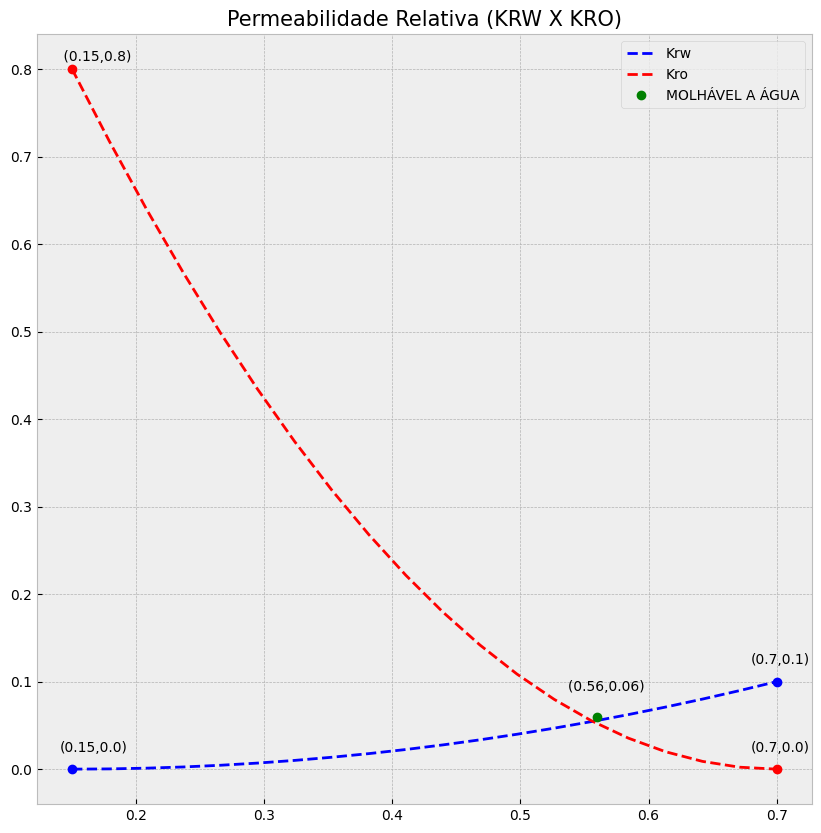

In [52]:
BL.wettability()

In [53]:
BL.table_Kr

,Saturação - ÁGUA,Kr - ÁGUA,Kr - ÓLEO
1,0.150000,0.000000,0.800000
2,0.178947,0.000277,0.718006
3,0.207895,0.001108,0.640443
4,0.236842,0.002493,0.567313
5,0.265789,0.004432,0.498615
6,0.294737,0.006925,0.434349
7,0.323684,0.009972,0.374515
8,0.352632,0.013573,0.319114
9,0.381579,0.017729,0.268144
10,0.410526,0.022438,0.221607


In [54]:
#excel =BL.table_Kr

In [55]:
#excel.to_excel('Dados_Permeabilidade.xls')
#excel.to_excel('Dados')

In [56]:
BL.solve()

[0.32894636 0.47226167 0.91975133 ... 0.65502592 0.55344753 0.26615696]
[0.01058572 0.03433143 0.19587342 ... 0.08431444 0.05380824 0.00446031]
[0.36411452 0.13716296 0.1277108  ... 0.0053492  0.05680033 0.49777132]
[0.57579537 0.88308032 0.93779871 ... 0.1707858  0.5905724  0.55129375]
[5.99344441e-02 1.77655126e-01 2.05165887e-01 ... 1.42826326e-04
 6.41666257e-02 5.32352642e-02]
[0.04079813 0.08864371 0.14954903 ... 0.74067482 0.03166783 0.05848211]
Valores de Sw1 encontrados: [0.0767005769762836 + 0.e-21*I, 0.239529724319573 + 0.e-23*I, 0.603862387127937 - 0.e-22*I]


,Saturação,Fluxo Fracionário
"(Swf,Fwf)",0.2579,0.5983
"(Sw1,Fw1)",0.2395,0.4857
"(Sw*3,Fw*3)",0.5440,0.9140


Frente de avanço do polímero 0.0421846829927885


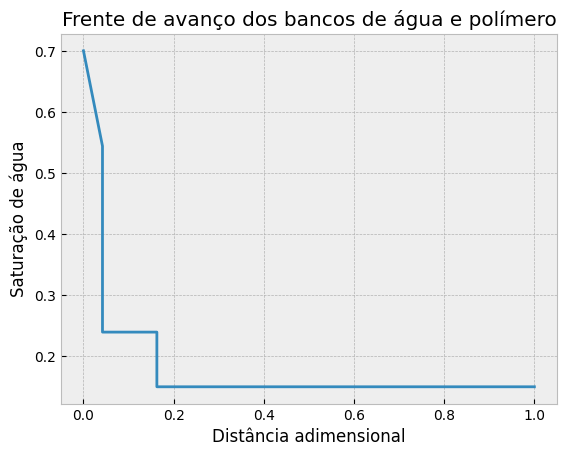

In [57]:
BL.posicaoADM()

In [58]:
BL.recoveryFactor()

,TEMPO BT (tD),NpD,Np,FR (%)
ÁGUA,0.184,0.184,22.079,0.2165
POLÍMERO,0.711,0.455,54.602,0.5353


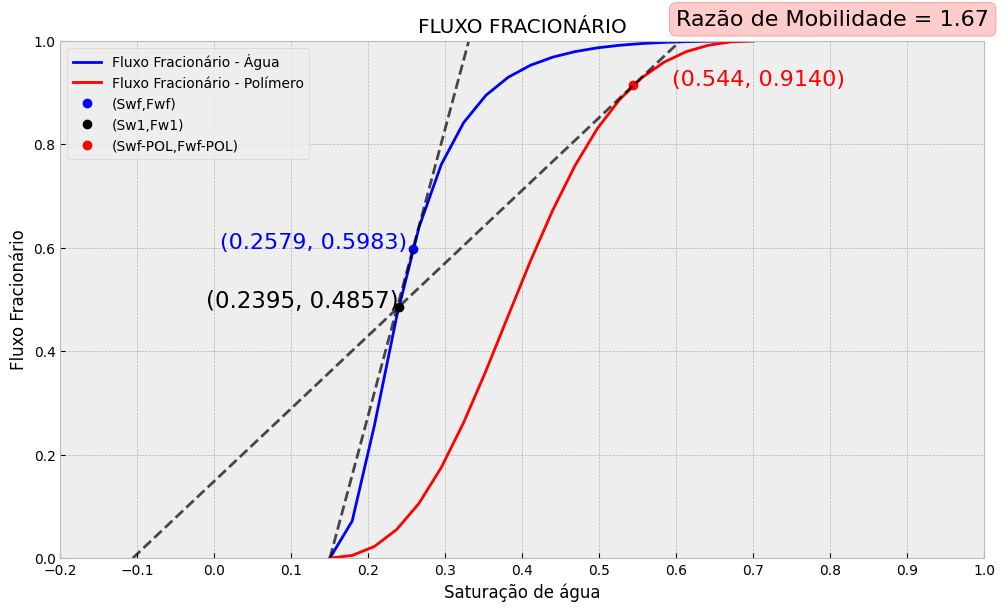

In [59]:
BL.plot()

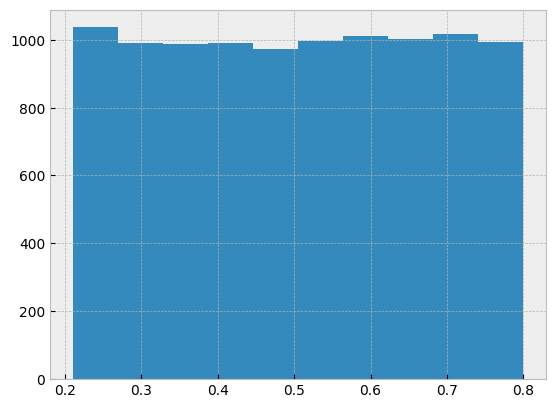

In [37]:
array = []
for i in range(0,10000):
    sw_values_wo = random.uniform(0.20+0.01, 0.8)
    array.append(sw_values_wo)
    
    
plt.hist(array)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


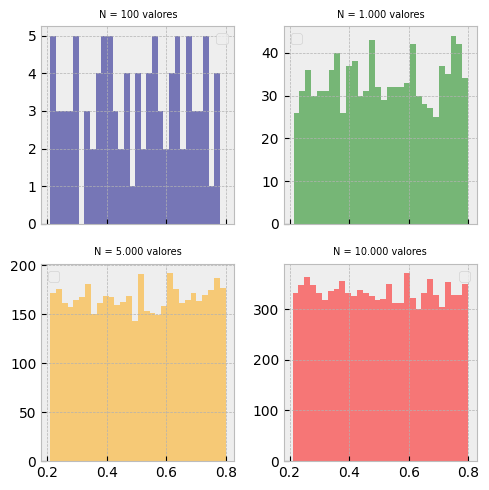

In [50]:


# Crie dados para os gráficos
array_um = []
array_dois = []
array_tres = []
array_quatro = []

#um
for i in range(0,100):
    sw_values_wo = random.uniform(0.20+0.01, 0.8)
    array_um.append(sw_values_wo)
#dois
for i in range(0,1000):
    sw_values_wo = random.uniform(0.20+0.01, 0.8)
    array_dois.append(sw_values_wo)
#três
for i in range(0,5000):
    sw_values_wo = random.uniform(0.20+0.01, 0.8)
    array_tres.append(sw_values_wo)
#quatro
for i in range(0,10000):
    sw_values_wo = random.uniform(0.20+0.01, 0.8)
    array_quatro.append(sw_values_wo)

# Crie uma figura e os subgráficos
fig, axs = plt.subplots(2, 2, figsize=(5, 5), sharex=True)

# Adicione os gráficos aos subgráficos
axs[0,0].hist(array_um, bins=30, color='navy', alpha=0.5)
axs[0,0].set_title('N = 100 valores',fontsize=7)
axs[0,0].legend()

axs[0,1].hist(array_dois, bins=30, color='green', alpha=0.5)
axs[0,1].set_title('N = 1.000 valores',fontsize=7)
axs[0,1].legend()

axs[1,0].hist(array_tres, bins=30, color='orange', alpha=0.5)
axs[1,0].set_title('N = 5.000 valores',fontsize=7)
axs[1,0].legend()

axs[1,1].hist(array_quatro, bins=30, color='red', alpha=0.5)
axs[1,1].set_title('N = 10.000 valores',fontsize=7)
axs[1,1].legend()

# Ajuste de layout
plt.tight_layout()

# Exibir os gráficos
plt.show()


In [42]:
joao()

11

In [16]:
a

NameError: name 'a' is not defined